#  Problem Set 2
**Zhiyu Fu**

## Problem 1

### (a)

In [5]:
%matplotlib notebook
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import integrate

In [2]:
dt = np.loadtxt("incomes.txt")

<IPython.core.display.Javascript object>


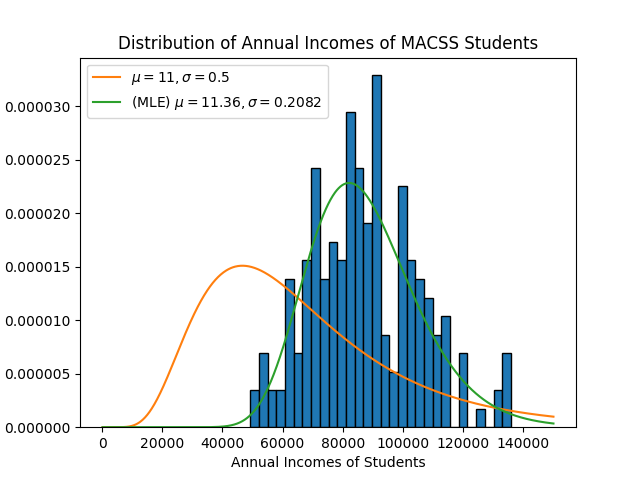

In [3]:
fig, ax = plt.subplots()
ax.hist(dt, bins = 30, normed = True, edgecolor = "Black")
ax.set(xlabel = "Annual Incomes of Students", 
       ylabel = "Density", 
       title = "Distribution of Annual Incomes of MACSS Students")

## (b)

First, construct the class of Log normal distribution.

In [72]:
class Random_Variable:
    def log_lik(self, dt, param = None):
        return np.sum(np.log(self.pdf(dt, param)))
    
    def param_array(self):
        pass
    
    def pdf(self, x, param = None):
        pass
    
    def MLE(self, dt):
        def crit(param):
            return -self.log_lik(dt, param)
        return minimize(crit, self.param_array(), method='BFGS')
    
    def cdf_integral(self, x):
        return integrate.quad(lambda x: self.pdf(x, param), 0, x)
        

class Log_Normal(Random_Variable):
    def __init__(self, mu, sigma):
        self.mu  = mu
        self.sigma = sigma
    
    def param_array(self):
        return np.array([self.mu, self.sigma])
    
    def pdf(self, x, param = None):
        if param is None:
            sigma = self.sigma
            mu = self.mu
            sigma2 = sigma ** 2
        else:
            mu, sigma2 = param
            sigma = np.sqrt(sigma2)
        return 1/x/sigma/np.sqrt(2*np.pi) * np.exp(-(np.log(x)-mu)**2/2/sigma2)
    
    def cdf(self, x, param = None):
        if param is None:
            sigma = self.sigma
            mu = self.mu
        else:
            mu, sigma = param
        return sts.norm.cdf((np.log(x) - mu)/sigma)

    

In [73]:
lognormal = Log_Normal(11, 0.5)
xval = np.linspace(150000/1000, 150000, 1000)
yval = lognormal.pdf(xval)
ax.plot(xval, yval, label = "$\mu = 11, \sigma = 0.5$")
ax.legend(loc = "best")
plt.show()

See the figure above for the plot.

In [74]:
print("The value of log likelihood for this parameterization is {}:".format(lognormal.log_lik(dt)))

The value of log likelihood for this parameterization is -2385.856997808558:


### (c)

In [75]:
results = lognormal.MLE(dt) # The MLE method is implemented above.
lognormal2 = Log_Normal(*results.xval)
xval = np.linspace(150000/1000, 150000, 1000)
yval = lognormal2.pdf(xval)
ax.plot(xval, yval, label = "(MLE) $\mu = {}, \sigma = {}$".format(results.x[0].round(2), results.x[1].round(4)))
ax.legend(loc = "best")
plt.show()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt


See the figure above for the plot.

In [67]:
print("mu_MLE = {}, sigma_MLE = {}, Log Likelihood = {}".format(results.x[0], results.x[1], -results.fun))
OffDiagNeg = np.array([[1, -1], [-1, 1]])
VCV = results.hess_inv * OffDiagNeg
print("VCV is:")
print(VCV)

mu_MLE = 506.01529524257927, sigma_MLE = -424.7230931015045, Log Likelihood = nan
VCV is:
[[ 6.54178912  5.62064126]
 [ 5.62064126  4.82975067]]


### (d)

In [9]:
chi2val = 2* (- results.fun - lognormal.log_lik(dt))
pval_h0 = 1 - sts.chi2.cdf(chi2val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

chi squared of H0 with 2 degrees of freedom p-value =  0.0


Therefore, the data in the incomes.txt are unlikely to come from the distribution in part (b).

### (e)

In [10]:
lognormal_mle = Log_Normal(*results.x)
print("The probability of earning more than $100,000: {}".format((1-lognormal_mle.cdf(100000)).round(2)))
print("The probability of earning less than $75,000: {}".format((lognormal_mle.cdf(75000)).round(2)))

The probability of earning more than $100,000: 0.23
The probability of earning less than $75,000: 0.26


Below is the likelihood function around the maximal point.

<IPython.core.display.Javascript object>


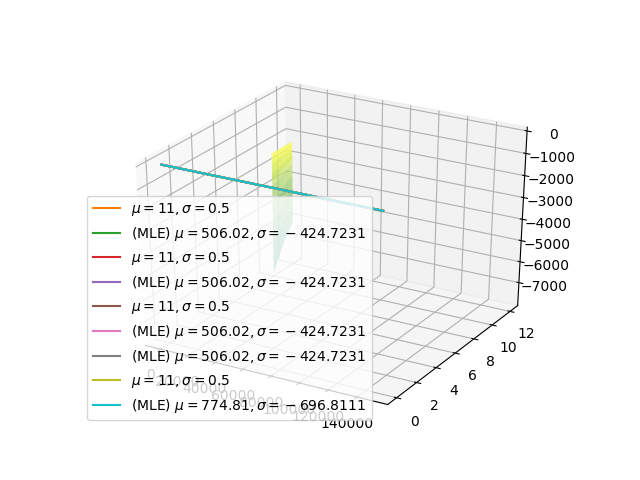

In [11]:
mu_vals = np.linspace(10,12,100)
sig_vals = np.linspace(0.18, 0.22, 100)
lnlik_vals = np.empty((100, 100))
for mu_ind in range(100):
    for sig_ind in range(100):
        param = mu_vals[mu_ind], sig_vals[sig_ind]
        lnlik_vals[mu_ind, sig_ind] = lognormal.log_lik(dt, param)
mu_mesh, sig_mesh = np.meshgrid(mu_vals, sig_vals)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
cmap1 =cm.get_cmap('summer')
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(sig_mesh, mu_mesh, lnlik_vals, rstride=8,
                cstride=1, cmap=cmap1)

## Part 2 Linear Regression and MLE

In [12]:
import pandas as pd
sick = pd.read_csv("sick.txt")

In [13]:
class Linear_Regression:
    def __init__(self, y, X, constant = True):
        self.y = y
        self.X = X
        self.N = len(y)
        if constant is True:
            self.X = np.concatenate((np.ones((self.N, 1)),self.X), axis = 1)
        self.m = self.X.shape[1]
    
    def log_lik(self, param):
        beta = param[0:self.m]
        sigma2 = param[self.m] *  param[self.m]
        return -self.N/2*np.log(2*np.pi*sigma2) - 1/2/sigma2*(self.y - self.X @ beta).T @ (self.y - self.X @ beta)

    def MLE(self):
        return minimize(lambda x: -self.log_lik(x), [0,1,1,1,1], method='BFGS')
    
    def analy_sol(self):
        X = self.X
        y = self.y
        return np.linalg.inv(X.T@X) @ X.T @ y

### (a)

In [14]:
lr = Linear_Regression(sick.loc[:, "sick"].values, sick.iloc[:, 1:].values)
mle_res = lr.MLE()
Hinv = mle_res.hess_inv
OffDiagNeg = -np.ones(Hinv.shape) + np.eye(Hinv.shape[0])*2
VCV = Hinv * OffDiagNeg


In [15]:
print("The estimates for beta_0 to sigma^2 are as follows:")
print(mle_res.x)
print("VCV matrix:")
print(VCV)
print("Log Likelihood:")
print(-mle_res.fun)

The estimates for beta_0 to sigma^2 are as follows:
[ 0.25164638  0.01293335  0.40050205 -0.00999167 -0.0030177 ]
VCV matrix:
[[  8.91408533e-07  -1.00005565e-08   1.84071941e-07   2.13152579e-08
    1.55285359e-09]
 [ -1.00005565e-08   3.92178294e-09   3.51383985e-08   2.50813129e-09
   -8.18697093e-12]
 [  1.84071941e-07   3.51383985e-08   3.58520564e-07  -2.29446260e-08
    1.03242814e-09]
 [  2.13152579e-08   2.50813129e-09  -2.29446260e-08   1.92070730e-09
   -2.87508758e-11]
 [  1.55285359e-09  -8.18697093e-12   1.03242814e-09  -2.87508758e-11
    2.10110718e-08]]
Log Likelihood:
876.8650463238776


### (b)

In [27]:
chi2val = 2*(-mle_res.fun - lr.log_lik([1, 0,0,0,0.01]))
pval_h0 = 1 - sts.chi2.cdf(chi2val, 5)
print('chi squared of H0 with 5 degrees of freedom p-value = ', pval_h0)

chi squared of H0 with 5 degrees of freedom p-value =  nan


The H0 is rejected.